### Deep Reinforcement Learning-based Image Captioning with Embedding Reward
Pranshu Gupta, Deep Learning @ Georgia Institute of Technology

In [2]:
# As usual, a bit of setup
from __future__ import print_function
import time, os, json
import numpy as np
import matplotlib.pyplot as plt
import nltk
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.nn import functional as F

from utils.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from utils.image_utils import image_from_url
from models.nets import PolicyNetwork, RewardNetwork, ValueNetwork
from search.search import GenerateCaptions, GenerateCaptionsWithBeamSearch
from torchsummary import summary
import metrics

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Working on: ", device)

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

max_seq_len = 17

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

Working on:  cuda:0


### Load MS-COCO data
We will use the Microsoft COCO dataset for captioning.

In [3]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

data["train_captions_lens"] = np.zeros(data["train_captions"].shape[0])
data["val_captions_lens"] = np.zeros(data["val_captions"].shape[0])
for i in range(data["train_captions"].shape[0]):
    data["train_captions_lens"][i] = np.nonzero(data["train_captions"][i] == 2)[0][0] + 1
for i in range(data["val_captions"].shape[0]):
    data["val_captions_lens"][i] = np.nonzero(data["val_captions"][i] == 2)[0][0] + 1


# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63
train_captions_lens <class 'numpy.ndarray'> (400135,) float64
val_captions_lens <class 'numpy.ndarray'> (195954,) float64


In [4]:
small_data = load_coco_data(max_train=50000)

In [30]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre2.pt'))
policyNet.train(mode=False)

valueNet = ValueNetwork(data["word_to_idx"]).to(device)
valueNet.load_state_dict(torch.load('./pretrained/valueNetwork_pre2.pt'))
valueNet.train(mode=False)

ValueNetwork(
  (valrnn): ValueNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (lstm): LSTM(512, 512)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

#### Lookahead Inference with Policy and Value Network

In [5]:
def GenerateCaptionsWithBeamSearchValueScoring(features, captions, model, beamSize=5):
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    gen_caps = torch.tensor(captions[:, 0:1], device=device).long()
    candidates = [(gen_caps, 0)]
    for t in range(max_seq_len-1):
        next_candidates = []
        for c in range(len(candidates)):
            output = model(features, candidates[c][0])
            probs, words = torch.topk(output[:, -1:, :], beamSize)
            for i in range(beamSize):
                cap = torch.cat((candidates[c][0], words[:, :, i]), axis=1)
                value = valueNet(features.squeeze(0), cap).detach()
                score = candidates[c][1] - 0.6*value.item() - 0.4*torch.log(probs[0, 0, i]).item()
                next_candidates.append((cap, score))
        ordered_candidates = sorted(next_candidates, key=lambda tup:tup[1])
        candidates = ordered_candidates[:beamSize]
    return candidates 

http://farm9.staticflickr.com/8313/8068463301_bb448fd235_z.jpg
<START> two people laying on the sand in the water <END>
URL Error:  Not Found http://farm3.staticflickr.com/2063/2452031839_03b3e0cd9a_z.jpg
http://farm3.staticflickr.com/2845/9498965434_821881c606_z.jpg
<START> there is a bench that is sitting on the grass <END>
http://farm1.staticflickr.com/130/415416350_55b6c8a64b_z.jpg
<START> two people walking towards an elephant <END>
http://farm4.staticflickr.com/3035/2385648150_d58d525cbe_z.jpg
<START> a group of people standing next to surfboards <END>
http://farm6.staticflickr.com/5338/9538594374_40f0919553_z.jpg
<START> three elephants are walking across the dirt <END>
http://farm9.staticflickr.com/8504/8302932673_81618d40e3_z.jpg
<START> there is a white <UNK> and a black couch <END>
http://farm6.staticflickr.com/5468/7244610102_482db5d7e2_z.jpg
<START> a young man sits in front of a bathroom sink <END>
http://farm1.staticflickr.com/36/87208689_7bb343b157_z.jpg
<START> a man s

http://farm9.staticflickr.com/8261/8710209636_e5eb8447aa_z.jpg
<START> on a court looking a bird <UNK> <END>
http://farm6.staticflickr.com/5322/9867137884_8da468d91c_z.jpg
<START> there is a stainless steel metal sink <END>
http://farm5.staticflickr.com/4007/4245908434_1c8f10da61_z.jpg
<START> a white bathroom filled with green blue <UNK> filled with <UNK> <UNK> <END>
http://farm8.staticflickr.com/7437/10040599586_f18f68aa6c_z.jpg
<START> a soccer player that is <UNK> a soccer ball <END>
http://farm6.staticflickr.com/5493/9408224451_0254d56cd1_z.jpg
<START> there is a silver bus parked on the railroad tracks <END>
http://farm1.staticflickr.com/138/331682401_63ac874993_z.jpg
<START> a young woman wearing a red <UNK> neck tie <END>
http://farm2.staticflickr.com/1297/4660495414_79643d17e2_z.jpg
<START> an image of a bathroom setting looking at the <UNK> sink <END>
URL Error:  Gone http://farm1.staticflickr.com/83/233003083_765401cd06_z.jpg
http://farm2.staticflickr.com/1310/542006651_17f7

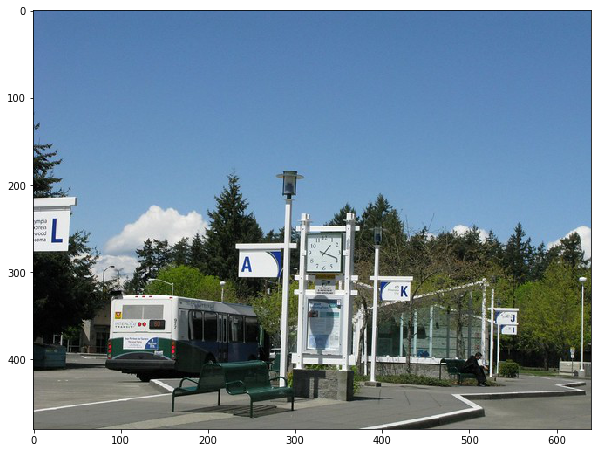

In [31]:
with torch.no_grad():
    max_seq_len = 17
    captions, features, urls = sample_coco_minibatch(small_data, batch_size=100, split='val')
    for i in range(100):
        gen_caps = []
        gen_caps.append(GenerateCaptions(features[i:i+1], captions[i:i+1], policyNet)[0])
        gen_caps.append(GenerateCaptionsWithBeamSearch(features[i:i+1], captions[i:i+1], policyNet)[0][0][0])
        gen_caps.append(GenerateCaptionsWithBeamSearchValueScoring(features[i:i+1], captions[i:i+1], policyNet)[0][0][0])
        decoded_tru_caps = decode_captions(captions[i], data["idx_to_word"])

        try:
            plt.imshow(image_from_url(urls[i]))
#             plt.show()
        except:
            continue
        print(urls[i])
        print(decode_captions(gen_caps[2], data["idx_to_word"])) #implement on the last method

### Caption Evaluation

In [6]:
def BLEU_score(gt_caption, sample_caption, w):
    """
    gt_caption: string, ground-truth caption
    sample_caption: string, your model's predicted caption
    Returns unigram BLEU score.
    """
    reference = [x for x in gt_caption.split(' ') 
                 if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    hypothesis = [x for x in sample_caption.split(' ') 
                  if ('<END>' not in x and '<START>' not in x and '<UNK>' not in x)]
    BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = [w])
    return BLEUscore

def evaluate_model(model):
    """
    model: CaptioningRNN model
    Prints unigram BLEU score averaged over 1000 training and val examples.
    """
    BLEUscores = {}
    for split in ['train', 'val']:
        minibatch = sample_coco_minibatch(data, split=split, batch_size=1000)
        gt_captions, features, urls = minibatch
        gt_captions = decode_captions(gt_captions, data['idx_to_word'])

        sample_captions = model.sample(features)
        sample_captions = decode_captions(sample_captions, data['idx_to_word'])

        total_score = 0.0
        for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
            total_score += BLEU_score(gt_caption, sample_caption)

        BLEUscores[split] = total_score / len(sample_captions)

    for split in BLEUscores:
        print('Average BLEU score for %s: %f' % (split, BLEUscores[split]))

In [7]:
caps0 = []
caps1 = []
caps2 = []
caps3 = []
f = open("./results/truth3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps0.append(x)
f = open("./results/greedy3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps1.append(x)
f = open("./results/beam3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps2.append(x)
f = open("./results/policyvalue3.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    caps3.append(x)

In [8]:
b1, b2, b3 = 0, 0, 0
for w in range(1, 5):
    for i in range(len(caps0)):
        b1 += BLEU_score(caps0[i], caps1[i], w)
        b2 += BLEU_score(caps0[i], caps2[i], w)
        b3 += BLEU_score(caps0[i], caps3[i], w)
    b1 /= len(caps0)
    b2 /= len(caps0)
    b3 /= len(caps0)
#     print("Greedy BLEU-" + str(w), ":", b1)
#     print("Beam BLEU-" + str(w), ":", b2)
    print("BLEU-" + str(w), ":", b3) #Agent BLEU

BLEU-1 : 0.2563426767182271
BLEU-2 : 0.09155483470073025
BLEU-3 : 0.03852101647793212
BLEU-4 : 0.018542079795694805


In [10]:
ref, hypo = metrics.load_textfiles(caps0, caps3)
print(metrics.score(ref, hypo))

The number of references is 1000
{'ROUGE_L': 0.2611785262449472, 'CIDEr': 0.4247729924235357}


### Training the Policy Network

In [5]:
pretrained = False

policyNetwork = PolicyNetwork(data["word_to_idx"]).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(policyNetwork.parameters(), lr=0.0001)

if pretrained:
    policyNetwork.load_state_dict(torch.load('./pretrained/policyNetwork_pre.pt'))  

In [6]:
batch_size = 100
bestLoss = 1.0
#0.006700546946376562

for epoch in range(100000): 
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float().unsqueeze(0)
    captions_in = torch.tensor(captions[:, :-1], device=device).long()
    captions_ou = torch.tensor(captions[:, 1:], device=device).long()
    output = policyNetwork(features, captions_in)
    
    loss = 0
    for i in range(batch_size):
        caplen = np.nonzero(captions[i] == 2)[0][0] + 1  # 2 = end of the sentence
        loss += (caplen/batch_size)*criterion(output[i][:caplen], captions_ou[i][:caplen])
    
    if loss.item() < bestLoss or (epoch == 99999 and bestLoss == 1.0):
        bestLoss = loss.item()
        torch.save(policyNetwork.state_dict(), "./pretrained/policyNetwork_pre2.pt")
        print("Best! epoch:", epoch, "loss:", loss.item())
        
    if (epoch % 1000 == 0):
        print("epoch:", epoch, "loss:", loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch: 0 loss: 82.62532043457031
epoch: 1000 loss: 36.1365966796875


KeyboardInterrupt: 

### Training the Reward Network

In [4]:
rewardNetwork = RewardNetwork(data["word_to_idx"]).to(device)
optimizer = optim.Adam(rewardNetwork.parameters(), lr=0.001)

# https://cs230-stanford.github.io/pytorch-nlp.html#writing-a-custom-loss-function
def VisualSemanticEmbeddingLoss(visuals, semantics):
    beta = 0.2
    N, D = visuals.shape
    
    visloss = torch.mm(visuals, semantics.t())
    visloss = visloss - torch.diag(visloss).unsqueeze(1)
    visloss = visloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    visloss = F.relu(visloss)
    visloss = torch.sum(visloss)/N
    
    semloss = torch.mm(semantics, visuals.t())
    semloss = semloss - torch.diag(semloss).unsqueeze(1)
    semloss = semloss + (beta/N)*(torch.ones((N, N)).to(device) - torch.eye(N).to(device))
    semloss = F.relu(semloss)
    semloss = torch.sum(semloss)/N
    
    return visloss + semloss        

In [14]:
batch_size = 50
bestLoss = 10000

for epoch in range(25000): #50000
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    captions = torch.tensor(captions, device=device).long()
    ve, se = rewardNetwork(features, captions)
    loss = VisualSemanticEmbeddingLoss(ve, se)
    
    if loss.item() < bestLoss or (epoch == 9999 and bestLoss == 10000):
        bestLoss = loss.item()
        torch.save(rewardNetwork.state_dict(), "./pretrained/rewardNetwork_pre.pt")
        print("Best! epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    rewardNetwork.rewrnn.hidden_cell.detach_()

Best! epoch: 0 loss: 2.0727500915527344
Best! epoch: 2 loss: 1.9821062088012695
Best! epoch: 24 loss: 1.6935951709747314
Best! epoch: 45 loss: 1.6715933084487915
Best! epoch: 48 loss: 1.589667797088623
Best! epoch: 233 loss: 1.5161621570587158
Best! epoch: 254 loss: 1.428794026374817
Best! epoch: 256 loss: 1.3831560611724854


In [6]:
def GetRewards(features, captions, model):
    visEmbeds, semEmbeds = model(features, captions)
    visEmbeds = F.normalize(visEmbeds, p=2, dim=1) 
    semEmbeds = F.normalize(semEmbeds, p=2, dim=1) 
    rewards = torch.sum(visEmbeds*semEmbeds, axis=1).unsqueeze(1)
    return rewards

In [6]:
rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
rewardNet.load_state_dict(torch.load('./pretrained/rewardNetwork_pre.pt'))
for param in rewardNet.parameters():
    param.require_grad = False
print(rewardNet)

policyNet = PolicyNetwork(data["word_to_idx"]).to(device)

if (os.path.exists('./pretrained/policyNetwork_pre2.pt')):
    policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre2.pt'))
    print("policyNet_pre2 is loaded")
else:
    policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre.pt'))
    print("policyNet_pre is loaded")
    
for param in policyNet.parameters():
    param.require_grad = False
print(policyNet)

valueNetwork = ValueNetwork(data["word_to_idx"]).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(valueNetwork.parameters(), lr=0.0001)
valueNetwork.train(mode=True)

RewardNetwork(
  (rewrnn): RewardNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (gru): GRU(512, 512)
  )
  (visual_embed): Linear(in_features=512, out_features=512, bias=True)
  (semantic_embed): Linear(in_features=512, out_features=512, bias=True)
)
policyNet_pre2 is loaded
PolicyNetwork(
  (caption_embedding): Embedding(1004, 512)
  (cnn2linear): Linear(in_features=512, out_features=512, bias=True)
  (lstm): LSTM(512, 512, batch_first=True)
  (linear2vocab): Linear(in_features=512, out_features=1004, bias=True)
)


ValueNetwork(
  (valrnn): ValueNetworkRNN(
    (caption_embedding): Embedding(1004, 512)
    (lstm): LSTM(512, 512)
  )
  (linear1): Linear(in_features=1024, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=1, bias=True)
)

In [17]:
batch_size = 50
bestLoss = 10000
max_seq_len = 17

for epoch in range(10000): #50000 
    captions, features, _ = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    features = torch.tensor(features, device=device).float()
    
    # Generate captions using the policy network
    captions = GenerateCaptions(features, captions, policyNet)
    
    # Compute the reward of the generated caption using reward network
    rewards = GetRewards(features, captions, rewardNet)
    
    # Compute the value of a random state in the generation process
#     print(features.shape, captions[:, :random.randint(1, 17)].shape)
    values = valueNetwork(features, captions[:, :random.randint(1, 17)])
    
    # Compute the loss for the value and the reward
    loss = criterion(values, rewards)
    
    if loss.item() < bestLoss:
        bestLoss = loss.item()
        torch.save(valueNetwork.state_dict(), "./pretrained/valueNetwork_pre2.pt")
        print("epoch:", epoch, "loss:", loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valueNetwork.valrnn.hidden_cell[0].detach_()
    valueNetwork.valrnn.hidden_cell[1].detach_()
    rewardNet.rewrnn.hidden_cell.detach_()

/home/wkawabe/git/Deep_Image_Captioning/code/search/search.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, device=device).float().unsqueeze(0)


epoch: 0 loss: 0.4606325328350067
epoch: 1 loss: 0.3747519850730896
epoch: 2 loss: 0.3455065190792084
epoch: 4 loss: 0.24872146546840668
epoch: 5 loss: 0.188638374209404
epoch: 7 loss: 0.11487375944852829
epoch: 10 loss: 0.1075485423207283
epoch: 11 loss: 0.09835158288478851
epoch: 12 loss: 0.08991406857967377
epoch: 17 loss: 0.08870091289281845
epoch: 19 loss: 0.05799233168363571
epoch: 28 loss: 0.03980918228626251
epoch: 36 loss: 0.031028911471366882
epoch: 37 loss: 0.030911892652511597
epoch: 40 loss: 0.02680399641394615
epoch: 45 loss: 0.025330547243356705
epoch: 46 loss: 0.01923516020178795
epoch: 56 loss: 0.013440925627946854
epoch: 63 loss: 0.009648796170949936
epoch: 73 loss: 0.009345472790300846
epoch: 74 loss: 0.009321537800133228
epoch: 75 loss: 0.006581632886081934
epoch: 87 loss: 0.00523336511105299
epoch: 90 loss: 0.00499338423833251
epoch: 94 loss: 0.004914876539260149
epoch: 99 loss: 0.003990316763520241
epoch: 114 loss: 0.002994220471009612
epoch: 121 loss: 0.002028771

## Reinforcement Learning
Advantage Actor Critic Model for Reinforcement Learning

In [12]:
class AdvantageActorCriticNetwork(nn.Module):
    def __init__(self, valueNet, policyNet):
        super(AdvantageActorCriticNetwork, self).__init__()

        self.valueNet = valueNet #RewardNetwork(data["word_to_idx"]).to(device)
        self.policyNet = policyNet #PolicyNetwork(data["word_to_idx"]).to(device)

    def forward(self, features, captions):
        # Get value from value network
        values = self.valueNet(features, captions)
        # Get action probabilities from policy network
        probs = self.policyNet(features.unsqueeze(0), captions)[:, -1:, :]        
        return values, probs 
    
def GetRewards(features, captions, model):
    visEmbeds, semEmbeds = model(features, captions)
    visEmbeds = F.normalize(visEmbeds, p=2, dim=1) 
    semEmbeds = F.normalize(semEmbeds, p=2, dim=1) 
    rewards = torch.sum(visEmbeds*semEmbeds, axis=1).unsqueeze(1)
    return rewards

In [13]:
rewardNet = RewardNetwork(data["word_to_idx"]).to(device)
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
valueNet = ValueNetwork(data["word_to_idx"]).to(device)

rewardNet.load_state_dict(torch.load('./pretrained/rewardNetwork_pre.pt'))

if (os.path.exists('./pretrained/policyNetwork_pre2.pt')):
    policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre2.pt'))
    print("policy pre2 loaded")
else:
    policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre.pt'))

if (os.path.exists('./pretrained/valueNetwork_pre2.pt')):
    valueNet.load_state_dict(torch.load('./pretrained/valueNetwork_pre2.pt'))
    print("valid pre2 loaded")
else:
    valueNet.load_state_dict(torch.load('./pretrained/valueNetwork_pre.pt'))

a2cNetwork = AdvantageActorCriticNetwork(valueNet, policyNet)
optimizer = optim.Adam(a2cNetwork.parameters(), lr=0.0001)

policy pre2 loaded
valid pre2 loaded


### Curriculum Learning

In [14]:
curriculum = [2, 4, 6, 8, 10, 12, 14]
episodes = 50
epochs = 50 #1000 but out of memory...    
small_data = load_coco_data(max_train=50000)
bestLoss = 1.0

for level in curriculum:
    
    for epoch in range(epochs):     
        episodicAvgLoss = 0
        
        captions, features, _ = sample_coco_minibatch(small_data, batch_size=episodes, split='train')
        features = torch.tensor(features, device=device).float() 
        captions = torch.tensor(captions, device=device).long()
        
        for episode in range(episodes):
            log_probs = []
            values = []
            rewards = []
            caplen = np.nonzero(captions[episode] == 2)[0][0] + 1
            
            if (caplen - level > 1):
                captions_in = captions[episode:episode+1, :caplen-level]
                features_in = features[episode:episode+1]

                for step in range(level):
                    value, probs = a2cNetwork(features_in, captions_in)
                    probs = F.softmax(probs, dim=2)

                    dist = probs.cpu().detach().numpy()[0,0]
                    action = np.random.choice(probs.shape[-1], p=dist)
         
                    gen_cap = torch.from_numpy(np.array([action])).unsqueeze(0).to(device)
                    captions_in = torch.cat((captions_in, gen_cap), axis=1)
                    
                    log_prob = torch.log(probs[0, 0, action])
                    
                    reward = GetRewards(features_in, captions_in, rewardNet) # visual-semantic embeddings
                    reward = reward.cpu().detach().numpy()[0, 0]
                    
                    rewards.append(reward)
                    values.append(value)
                    log_probs.append(log_prob)
            else: 
                continue
                
            values = torch.FloatTensor(values).to(device)
            rewards = torch.FloatTensor(rewards).to(device)
            log_probs = torch.stack(log_probs).to(device)
            
            advantage = (values - rewards) #values - rewards
            actorLoss = (-log_probs * advantage).mean()
            
            criticLoss = 0.5 * advantage.pow(2).mean()
#             criticLoss  = (values * (values - rewards)).mean()

#             EntropyLoss = (probs * torch.log(probs)).mean() #Originally didnt exist
            
#             loss = actorLoss + criticLoss + 0.1 * EntropyLoss
            loss = actorLoss + criticLoss 
            episodicAvgLoss += loss.item()/episodes
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        del values
        del rewards
        del log_probs
        del features
        del captions
        print("cur:", level, " epoch:", epoch, episodicAvgLoss)
        

bestLoss = episodicAvgLoss
torch.save(policyNet.state_dict(), "./pretrained/policyNetwork_final2.pt")
torch.save(valueNet.state_dict(), "./pretrained/valueNetwork_final2.pt")
# torch.save(rewardNet.state_dict(), "./pretrained/rewardNetwork_final.pt")
print("Models are saved")

cur: 2  epoch: 0 -0.0013570505720417708
cur: 2  epoch: 1 0.0383540064932913
cur: 2  epoch: 2 0.008614032087207308
cur: 2  epoch: 3 0.0034913530183621356
cur: 2  epoch: 4 0.00953731777000939
cur: 2  epoch: 5 0.011594866397863371
cur: 2  epoch: 6 -0.007877030844101683
cur: 2  epoch: 7 0.0026483521176851347
cur: 2  epoch: 8 0.01704023971804418
cur: 2  epoch: 9 -0.02184684053980163
cur: 2  epoch: 10 0.011135645035828928
cur: 2  epoch: 11 -0.009428291485382942
cur: 2  epoch: 12 -0.0033622965769609433
cur: 2  epoch: 13 0.010502969508452226
cur: 2  epoch: 14 -0.0030888304905420227
cur: 2  epoch: 15 -0.005007598375086674
cur: 2  epoch: 16 0.02408215202092833
cur: 2  epoch: 17 -0.016301989444909838
cur: 2  epoch: 18 0.008187746940093348
cur: 2  epoch: 19 0.006201151132629118
cur: 2  epoch: 20 0.005101293935549619
cur: 2  epoch: 21 0.004274615313170215
cur: 2  epoch: 22 -5.1189148216508444e-05
cur: 2  epoch: 23 -0.010234786911314587
cur: 2  epoch: 24 0.020360601786387628
cur: 2  epoch: 25 0.0072

cur: 10  epoch: 10 0.008194148357142694
cur: 10  epoch: 11 0.009361034519097302
cur: 10  epoch: 12 0.009135935067897666
cur: 10  epoch: 13 0.007428477497596758
cur: 10  epoch: 14 -0.003003644546261058
cur: 10  epoch: 15 0.0014550028252415356
cur: 10  epoch: 16 0.0041692670248448865
cur: 10  epoch: 17 0.0026429006690159443
cur: 10  epoch: 18 0.010167898477520794
cur: 10  epoch: 19 0.010410312457825055
cur: 10  epoch: 20 0.0020915939932456234
cur: 10  epoch: 21 -0.0032464030772098333
cur: 10  epoch: 22 0.009696354296902425
cur: 10  epoch: 23 -0.0015047255321405833
cur: 10  epoch: 24 0.005046237599017331
cur: 10  epoch: 25 0.0003503495926270262
cur: 10  epoch: 26 0.007635675421333871
cur: 10  epoch: 27 0.0029430330754257735
cur: 10  epoch: 28 0.006263659481192007
cur: 10  epoch: 29 0.0007740318158175806
cur: 10  epoch: 30 0.010660818025353364
cur: 10  epoch: 31 0.007431467690039427
cur: 10  epoch: 32 0.003007969536120072
cur: 10  epoch: 33 0.003100579286110588
cur: 10  epoch: 34 0.0033377

## Final Evaluation

In [21]:
policyNet = PolicyNetwork(data["word_to_idx"]).to(device)
policyNet.load_state_dict(torch.load('./pretrained/policyNetwork_pre2.pt'))
valueNet = ValueNetwork(data["word_to_idx"]).to(device)
valueNet.load_state_dict(torch.load('./pretrained/valueNetwork_pre2.pt'))

<All keys matched successfully>

In [22]:
with open('results/policyvalue4.txt', 'w'):
    pass
with open('results/truth4.txt', 'w'):
    pass

Truth   :  <START> a cat is standing on top of a toilet <END>
Output:  <START> there is an image of a horse that is talking <END>
Truth   :  <START> train at a train station on a clear day in a city <END>
Output:  <START> there is a airplane that is sitting on the ground <END>
Truth   :  <START> overhead view of <UNK> open toilet and bathtub full of clothes <END>
Output:  <START> a bathroom that has a toilet and tub in it <END>
Truth   :  <START> people playing a game on green grass in front of a building <END>
Output:  <START> a crowd of people standing near a fence <END>
Truth   :  <START> people jumping snow board in the air <END>
Output:  <START> there is a person that is on some skis <END>
Truth   :  <START> a black and white photo of people sitting on the bench <END>
Output:  <START> there is a man doing a trick on a skateboard a ramp <END>
Truth   :  <START> <UNK> many pink <UNK> <UNK> to <UNK> from for this little girl <END>
Output:  <START> a close shot of a little boy wearing

Truth   :  <START> an <UNK> snowboarder is coming down the slope <END>
Output:  <START> a man riding skis on top of a snow boards <END>
Truth   :  <START> a piece of cake is on a plate with an <UNK> flag <UNK> in it <END>
Output:  <START> a piece of cake with <UNK> on it beside a fork <END>
Truth   :  <START> a group of people sitting around a table <END>
Output:  <START> a group of people standing around each other <END>
Truth   :  <START> a basket containing bananas and <UNK> and <UNK> <END>
Output:  <START> several oranges sitting on top of a white plate <END>
Truth   :  <START> a city with tall buildings filled with tall buildings <END>
Output:  <START> several cars lined up in front of a clock tower <END>
Truth   :  <START> a bathroom that has a glass shower door <END>
Output:  <START> a bathroom shower with a white bath tub sitting toilet <END>
Truth   :  <START> a clock tower in the middle of a <UNK> <END>
Output:  <START> a group of people throw <UNK> and <UNK> at a small park 

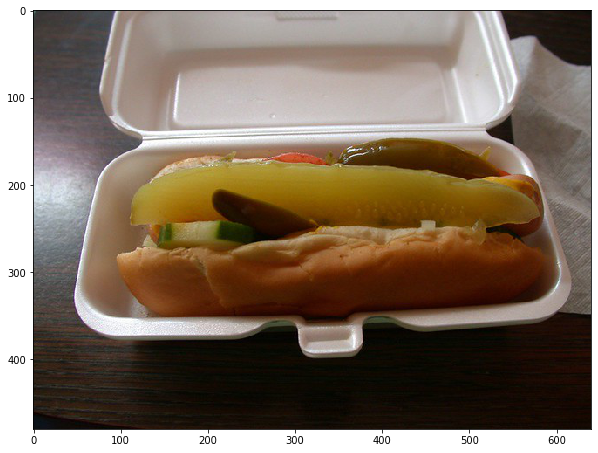

In [23]:
num_of_sentences = 150

with torch.no_grad():
    max_seq_len = 17
    captions, features, urls = sample_coco_minibatch(small_data, batch_size=1000, split='val')
    gen_caps = []
    tru_caps = []
    with open('results/policyvalue4.txt', mode='w') as f:
        with open('results/truth4.txt', mode='w') as f2:
            count = 0
            
            for i in range(num_of_sentences):
                try:    #pass if the url doesnt exist
                    plt.imshow(image_from_url(urls[i]))
                    count += 1
                except:
                    continue
                if count >= 101: 
                    break 
                decoded_tru_caps = decode_captions(captions[i], data["idx_to_word"])
                gen_cap = GenerateCaptionsWithBeamSearchValueScoring(features[i:i+1], captions[i:i+1], policyNet)[0][0][0]
                decoded_gen_caps = decode_captions(gen_cap, data["idx_to_word"])


                f.writelines(' '.join(decoded_gen_caps))
                f.write('\n')

                f2.writelines(' '.join(decoded_tru_caps))
                f2.write('\n')
                
                print("Truth   : ", decoded_tru_caps) 
                print("Output: ", decoded_gen_caps) 

In [24]:
tru_caps = []
gen_caps = []

f = open("./results/truth4.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    tru_caps.append(x)
    
f = open("./results/policyvalue4.txt", "r")
for x in f:
    x = " ".join([w for w in x.split(' ') if ('<END>' not in w and '<START>' not in w and '<UNK>' not in w)])
    gen_caps.append(x)

In [25]:
bleu = 0
for w in range(1, 5):
    for i in range(len(tru_caps)):

        bleu += BLEU_score(tru_caps[i], gen_caps[i], w)
        bleu /= len(tru_caps)

    print("BLEU-" + str(w), ":", bleu)

BLEU-1 : 0.004792424342150021
BLEU-2 : 0.004447331904587919
BLEU-3 : 0.00413379911769512
BLEU-4 : 0.0038463811300240365


In [20]:
ref, hypo = metrics.load_textfiles(tru_caps, gen_caps)
print(metrics.score(ref, hypo))

The number of references is 100
{'ROUGE_L': 0.4069321631241912, 'CIDEr': 0.002096955912181293}
